前排定义一下训练参数

In [1]:
import os
# 训练循环次数
num_epochs = 1

# batch大小
batch_size = 256

# lstm层中包含的unit个数
rnn_size = 256

# lstm层数
num_layers = 3

# embedding layer的大小
embed_dim = 300

# 训练步长
seq_length = 30

# 学习率
learning_rate = 0.001

#dropout keep
output_keep_prob = 0.8
input_keep_prob = 1.0

# 优化器
grad_clip = 5.

decay_rate = 0.97
init_from = None
save_every = 1000
# 保存模型
save_dir = './save'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
# 保存logs   
log_dir = './logs'
if not os.path.isdir(log_dir):
    os.makedirs(log_dir)

# 保存数据和词汇
data_dir = './temp'
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)
    
input_file = os.path.join(data_dir, "爵迹I II.txt")
vocab_file = os.path.join(data_dir, "vocab.pkl")
tensor_file = os.path.join(data_dir, "data.npy")
_file = os.path.join(save_dir, 'chars_vocab.pkl')

首先加载数据集 <p>
使用到的是**`爵迹`**这本小说<p>
无论小说和电影都能给人很深刻的印象....

In [2]:
with open(input_file, 'r',encoding = 'gbk') as f:
        text = f.read()

**预览一下部分内容<p>**
果然一股东方神话、字里行间透露出45度角仰望天空的忧伤气息扑面而来<p>

In [3]:
text[500:800]

'而来？传说中至高无上的【白银祭司】又掌握着怎样的真相？这场旷世之战，究竟要将主角的命运引向王者的宝座，还是惨烈的死亡？\n\n    \n\n    序章  神遇\n\n    \n\n    漫天翻滚的碎雪，仿佛巨兽抖落的白色绒毛，纷纷扬扬地遮蔽着视线。\n\n    这块大陆的冬天已经来临。\n\n    南方只是开始不易察觉地降温，凌晨的时候窗棂上会看见霜花，但是在这里——大陆接近极北的尽头，已经是一望无际的苍茫肃杀。大块大块浮动在海面上的冰山彼此不时地撞击着，在天地间发出巨大的锐利轰鸣声，坍塌的冰块砸进大海，掀起白色的浪涛。辽阔的黑色冻土在接连几天的大雪之后，变成了一片茫茫的雪原。这已经是深北之地了，连绵不断'

* 做一些数据预处理，去掉一写无关的字符和空格，去掉书籍前几行没用的介绍

In [4]:
import re
pattern = re.compile('\[.*\]|<.*>|\.+|【|】| +|\\r|\\n')
text = pattern.sub('', text.strip()) 

In [5]:
text[500:800]

'巨兽抖落的白色绒毛，纷纷扬扬地遮蔽着视线。这块大陆的冬天已经来临。南方只是开始不易察觉地降温，凌晨的时候窗棂上会看见霜花，但是在这里——大陆接近极北的尽头，已经是一望无际的苍茫肃杀。大块大块浮动在海面上的冰山彼此不时地撞击着，在天地间发出巨大的锐利轰鸣声，坍塌的冰块砸进大海，掀起白色的浪涛。辽阔的黑色冻土在接连几天的大雪之后，变成了一片茫茫的雪原。这已经是深北之地了，连绵不断的冰川仿佛怪兽的利齿般将天地的尽头紧紧咬在一起，地平线消失在刺眼的白色冰面之下。天空被厚重的云层遮挡，光线仿佛蒙着一层尘埃，混沌地洒向大地。混沌的风雪在空旷的天地间吹出一阵又一阵仿佛狼嗥般的凄厉声响。拳头大小的纷乱大雪里，'

####  感觉预处理后效果还可以.没那么乱了，开始做词映射
1. 首先做词频统计，再降序排序，因为用的是char级的所以这一步是没什么必要的，统计有多少个汉字和字符，其实可以用``chars=set(text)``代替
2. 将统计结果作为语料库，存入本地pkl文件中，方便调用

In [6]:
import collections
from six.moves import cPickle
counter = collections.Counter(text)
counter = sorted(counter.items(), key=lambda x: -x[1])
chars, _  = zip(*counter)
with open(vocab_file, 'wb') as f:
    cPickle.dump(chars, f)

对词汇表字符(包括\n哦)做一个数字索引，并用这个数字索引来代替这个汉字<p>
保存字词映射表

In [7]:
vocab_size = len(chars)
vocab = dict(zip(chars, range(vocab_size)))
with open(_file, 'wb') as f:
    cPickle.dump((chars, vocab), f)

1. 将整本书的内容，做一下 汉字/字符  - 数字 的变化。
2. 这样原来的一本书变可以用一个由N个数字组成的列表表示了
3. 最后把向量化的这本书保存下来，方便之后调用

In [8]:
import numpy as np
text_tensor = np.array(list(map(vocab.get, text)))
np.save(tensor_file, text_tensor)

构建训练所需数据格式

In [9]:
num_batches = int(text_tensor.size / (batch_size * seq_length))

if num_batches == 0:
    assert False, "Not enough data. Make seq_length and batch_size small."

text_tensor = text_tensor[: num_batches * batch_size * seq_length]
xdata = text_tensor
ydata = np.copy(text_tensor)

#循环神经网络，最后一个输出为最先一个输入
ydata[:-1] = xdata[1:]
ydata[-1] = xdata[0]
x_batches = np.split(xdata.reshape( batch_size, -1),
                          num_batches, 1)
y_batches = np.split(ydata.reshape(batch_size, -1),
                          num_batches, 1)

构建一个生成器,生成批次数据

In [10]:
def next_batch():
    x, y = x_batches[pointer], y_batches[pointer]
    return x, y  

In [11]:
import time
import tensorflow as tf
from tensorflow.contrib import rnn
from tensorflow.contrib import legacy_seq2seq
from tensorflow.python.framework import ops
ops.reset_default_graph()

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


构建LSTM的cell

In [12]:
cells = []
for _ in range(num_layers):
    cell = rnn.LSTMCell(rnn_size)
    if output_keep_prob < 1.0 or input_keep_prob < 1.0:
        cell = rnn.DropoutWrapper(cell,
                                  input_keep_prob=input_keep_prob,
                                  output_keep_prob=output_keep_prob)
    cells.append(cell)

cell = rnn.MultiRNNCell(cells, state_is_tuple=True)

初始化占位符,随机化参数矩阵，

In [13]:
input_data = tf.placeholder(tf.int32, [batch_size, seq_length])
targets = tf.placeholder(tf.int32, [batch_size, seq_length])
initial_state = cell.zero_state(batch_size, tf.float32)

with tf.variable_scope('rnnlm'):
    softmax_w = tf.get_variable("softmax_w",[rnn_size, vocab_size])
    softmax_b = tf.get_variable("softmax_b", [vocab_size])

将input转化为词嵌入向量

In [14]:
embedding = tf.get_variable("embedding", [vocab_size, rnn_size])
inputs = tf.nn.embedding_lookup(embedding, input_data)

拆散input_data放入rnn模型

In [15]:
inputs = tf.split(inputs, seq_length, 1)
inputs = [tf.squeeze(input_, [1]) for input_ in inputs]

decoder的输出和最终状态

In [16]:
outputs, last_state = legacy_seq2seq.rnn_decoder(inputs, initial_state, cell, scope='rnnlm')
output = tf.reshape(tf.concat(outputs, 1), [-1, rnn_size])

对输出层做softmax

In [17]:
logits = tf.matmul(output, softmax_w) + softmax_b
probs = tf.nn.softmax(logits)

loss

In [18]:
loss = legacy_seq2seq.sequence_loss_by_example(
        [logits],
        [tf.reshape(targets, [-1])],
        [tf.ones([batch_size * seq_length])])
with tf.name_scope('cost'):
    cost = tf.reduce_sum(loss) / batch_size / seq_length
final_state = last_state
lr = tf.Variable(0.0, trainable=False)
tvars = tf.trainable_variables()

优化器

In [19]:
grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars),grad_clip)
with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(lr)

In [20]:
train_op = optimizer.apply_gradients(zip(grads, tvars))

开始训练

In [21]:
train_loss_result = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(tf.global_variables())
    # restore model
    if init_from is not None:
        saver.restore(sess, ckpt)
    
    for i in range(num_epochs):
        sess.run(tf.assign(lr,learning_rate * (decay_rate ** i)))
        state = sess.run(initial_state)
        pointer = 0
        for j in range(num_batches):
            start = time.time()
            x, y = next_batch()
            pointer +=1
            feed = {input_data: x, targets: y}
            
            for a, (c, h) in enumerate(initial_state):
                feed[c] = state[a].c
                feed[h] = state[a].h

      
            train_loss, state, _ = sess.run([ cost, final_state,train_op], feed)
            train_loss_result.append(train_loss)

            end = time.time()
            print("{}/{} (epoch {}), train_loss = {:.3f}, time/batch = {:.3f}"
                  .format(i * num_batches + j,
                          num_epochs * num_batches,
                          i, train_loss, end - start))
            if (i * num_batches + j) % save_every == 0\
                    or (i == num_epochs-1 and
                        j == num_batches-1):
                # save for the last result
                checkpoint_path = os.path.join(save_dir, 'model.ckpt')
                saver.save(sess, checkpoint_path,
                           global_step=i * num_batches + j)
                print("model saved to {}".format(checkpoint_path))

0/38 (epoch 0), train_loss = 7.984, time/batch = 1.575
model saved to ./save\model.ckpt
1/38 (epoch 0), train_loss = 7.982, time/batch = 1.185
2/38 (epoch 0), train_loss = 7.976, time/batch = 1.228
3/38 (epoch 0), train_loss = 7.954, time/batch = 1.114
4/38 (epoch 0), train_loss = 7.862, time/batch = 1.122
5/38 (epoch 0), train_loss = 7.589, time/batch = 1.122
6/38 (epoch 0), train_loss = 7.271, time/batch = 1.117
7/38 (epoch 0), train_loss = 7.042, time/batch = 1.112
8/38 (epoch 0), train_loss = 6.839, time/batch = 1.113
9/38 (epoch 0), train_loss = 6.620, time/batch = 1.116
10/38 (epoch 0), train_loss = 6.459, time/batch = 1.123
11/38 (epoch 0), train_loss = 6.334, time/batch = 1.223
12/38 (epoch 0), train_loss = 6.277, time/batch = 1.109
13/38 (epoch 0), train_loss = 6.206, time/batch = 1.111
14/38 (epoch 0), train_loss = 6.200, time/batch = 1.132
15/38 (epoch 0), train_loss = 6.233, time/batch = 1.142
16/38 (epoch 0), train_loss = 6.230, time/batch = 1.113
17/38 (epoch 0), train_lo

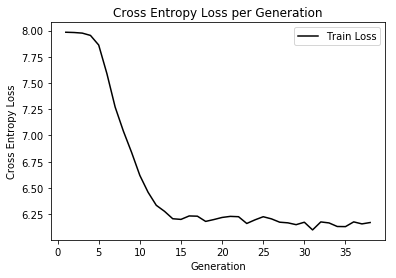

In [23]:
import matplotlib.pyplot as plt
_x = [i for i in range(1,len(train_loss_result)+1)]
plt.plot(_x, train_loss_result, 'k-', label='Train Loss')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

使用语言模型做测试 [debuging......](www.bug.com)

In [18]:
prime = '悲伤逆流成河'